 Copyright (C) 2012-2017 Corrado Maurini.
 Licensed under the GNU LGPL Version 3.

 Last changed: 12/10/2017

 This example solve the bound constrained minimization problem
 in the domain $(x,y)$ in $\Omega \equiv (0,L_x)\times(0,L_y)$

 $\mathrm{min}\, F(u),\qquad$ with  $\;0\leq u\leq 1,\;u(0,y)= 0,\;u(L_x,y) = 1$

 where $F(u)$ is the functional defined by the form

 $$F(u) =\int_\Omega \left(\frac{w(u)}{\ell}+\ell\, \nabla u\cdot  \nabla u\right)\mathrm{d}x$$

In [1]:
from fenics import *
import sympy
import numpy as np
import matplotlib.pyplot as plt
parameters.plotting_backend = "matplotlib"
%matplotlib inline

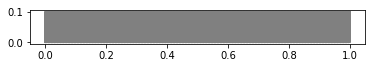

In [2]:
# Create mesh and define function space
Lx = 1; Ly = .1
Lx = 1.; Ly = .1
mesh = RectangleMesh(mpi_comm_world(), Point(0., 0.), Point(Lx, Ly), 200, 20)
# Define Dirichlet boundaries
def left(x,on_boundary):
    return on_boundary and x[0]==0.

def rigth(x,on_boundary):
    return on_boundary and x[0]==1.
plot(mesh)

In [3]:
V = FunctionSpace(mesh, "Lagrange", 1)
# Define variational problem
alpha = Function(V)
dalpha = TrialFunction(V)
beta = TestFunction(V)
ell = Constant(0.25) 
# The energy
def w(alpha):
    return alpha
F = (ell*inner(grad(alpha), grad(alpha)) + w(alpha)/ell)*dx
# First directional derivative in alpha along the direction beta
dF = derivative(F,alpha,beta)
ddF = derivative(dF,alpha,dalpha)

In [4]:
# Define boundary conditions
bc_l = DirichletBC(V,  Constant(0.0), left)
bc_r = DirichletBC(V, Constant(1.0), rigth)
bc=[bc_l,bc_r]

# Define the upper and lower bounds
ub = interpolate(Constant(1.), V)
lb = interpolate(Constant(0.), V)

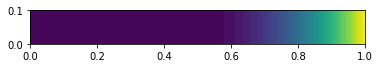

In [5]:
problem_nl = NonlinearVariationalProblem(dF, alpha, bc, J = ddF)
problem_nl.set_bounds(lb, ub)
# set up the solver
solver_nl = NonlinearVariationalSolver(problem_nl)
snes_solver_parameters_bounds = {"nonlinear_solver": "snes",
                          "snes_solver": {"linear_solver": "umfpack",
                                          "maximum_iterations": 100,
                                          "report": True,
                                          "line_search": "basic",
                                          "method":"vinewtonrsls",
                                          "absolute_tolerance":1e-6,
                                          "relative_tolerance":1e-6,
                                          "solution_tolerance":1e-6}}
solver_nl.parameters.update(snes_solver_parameters_bounds)
info(solver_nl.parameters,True)
# solve the problem
solver_nl.solve()
plot(alpha)

Text(0,0.5,'$\\alpha$')

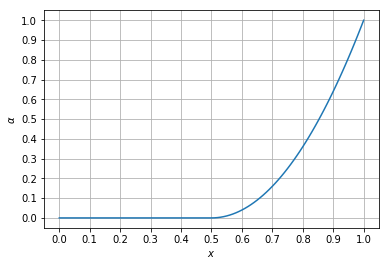

In [6]:
xs  = np.linspace(0,1,101)
alphas = [alpha(xx,Ly/2) for xx in xs]
fig = plt.figure()
ax = fig.gca()
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_yticks(np.arange(0, 1.1, 0.1))
plt.plot(xs,alphas, label = "alpha")
plt.grid()
plt.xlabel(r"$x$"); plt.ylabel(r"$\alpha$")

In [7]:
# Analytical solution for the dissipated energy
z = sympy.Symbol("z")
cw = sympy.integrate(2*sympy.sqrt(w(z)),(z,0,1))
# Check the solution with the analytical result
print("Energy of the solution (Numerical / Analytical): %.4g / %.4g" % (assemble(F),float(cw)*Ly))
# plot the solution
File("results/uTAO.pvd") << alpha

Energy of the solution (Numerical / Analytical): 0.1333 / 0.1333


In [8]:
cw

4/3